In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# source files
from scripts.calibrated_regression import CalibratedRegression
from scripts.data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

## Creating Data

(1250,) (250,) (1250,) (250,)


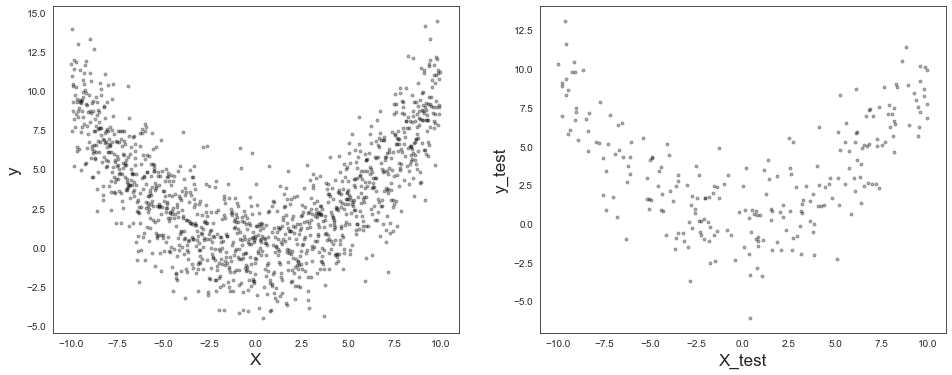

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

## Polynomial Regression Model

Priors:

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

In [3]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1244.57draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.101194,0.000939,0.000028,0.099220,0.102945,1408.453371,1.000149
b,0.006898,0.004883,0.000123,-0.002062,0.016673,1504.463952,0.999501
c,-0.025742,0.041528,0.001253,-0.111055,0.051914,1390.062235,0.999521


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    return (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise

,X,y,predicted_cdf,empirical_cdf
0,4.262842,1.608663,0.400,0.420
1,1.207472,1.286845,0.887,0.708
2,-1.087392,2.123978,0.979,0.856
3,3.795864,4.126114,0.998,0.908
4,-9.866578,5.169333,0.000,0.048


[5.83333333e-04 5.81000000e-01 9.99305556e-01]


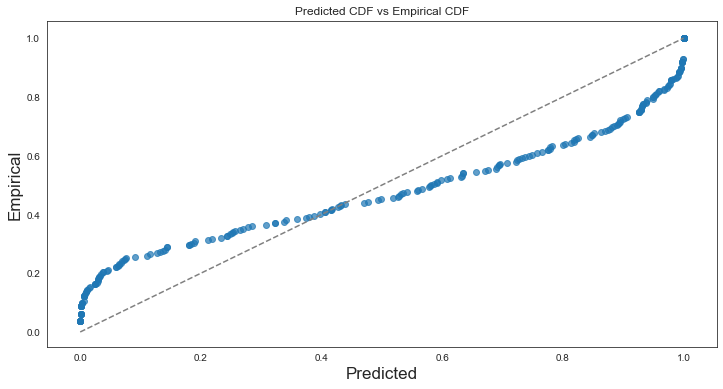

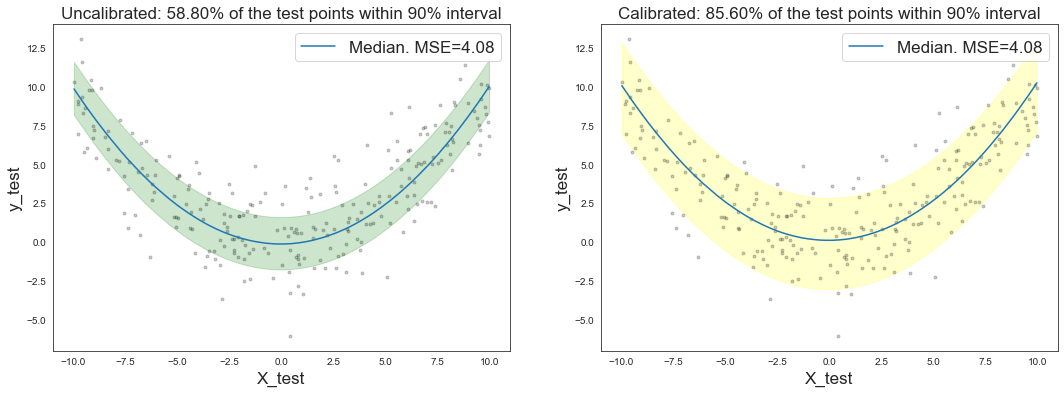

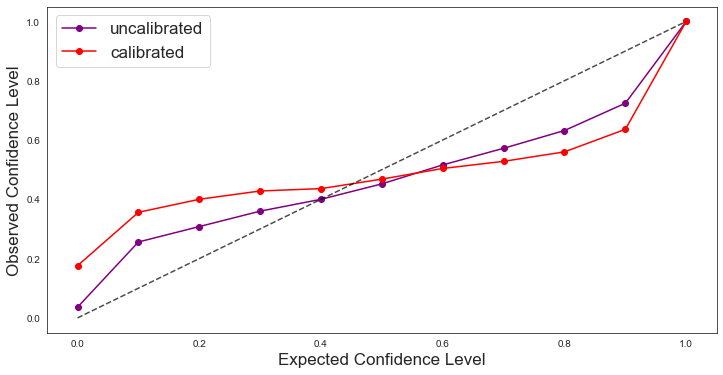

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax)

# prediction
post_pred_test, new_quantiles = calib.predict(X_test, y_test, quants)
cal_lower, cal_median, cal_upper = np.quantile(post_pred_test, new_quantiles, axis=1)
unc_lower, unc_median, unc_upper = np.quantile(post_pred_test, quants, axis=1)
perc_within_unc = np.mean((y_test <= unc_upper)&(y_test >= unc_lower))
perc_within_cal = np.mean((y_test <= cal_upper)&(y_test >= cal_lower))

# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].plot(X_test, y_test, 'o', color='black', alpha=0.2, markersize=3)
ax[0].set_title(f'Uncalibrated: {100*perc_within_unc:.2f}% of the test points within 90% interval', fontsize=17)
ax[0].set_xlabel('X_test', fontsize=17)
ax[0].set_ylabel('y_test', fontsize=17)
ax[0].fill_between(X_test, unc_lower, unc_upper, color='green', alpha=0.2)
ax[0].plot(X_test, unc_median, label=f'Median. MSE={mean_squared_error(y_test, unc_median):.2f}')
ax[0].legend(fontsize=17)

ax[1].plot(X_test, y_test, 'o', color='black', alpha=0.2, markersize=3)
ax[1].set_title(f'Calibrated: {100*perc_within_cal:.2f}% of the test points within 90% interval', fontsize=17)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17)
ax[1].fill_between(X_test, cal_lower, cal_upper, color='yellow', alpha=0.2)
ax[1].plot(X_test, cal_median, label=f'Median. MSE={mean_squared_error(y_test, cal_median):.2f}')
ax[1].legend(fontsize=17)

# diagnostic plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_diagnostic_curve(ax, intervals=np.linspace(0,1,11).reshape(-1,1));

---